In [1]:
from pymongo import MongoClient
import pandas as pd
import urllib.parse

# Your credentials
username = "soundDev"
password = "e1kemyOwhAYXNidM"
cluster_url = "atlas-sql-681e2eb821f0c21b8b5e1712-lkspta.a.query.mongodb.net"
database_name = "checkoutETL"
collection_name = "transactions"

# URL encode username and password in case of special chars
username = urllib.parse.quote_plus(username)
password = urllib.parse.quote_plus(password)

# Build the MongoDB connection string (note: mongodb:// not mongodb+srv://)
mongo_uri = (
    f"mongodb://{username}:{password}@{cluster_url}/{database_name}"
    "?ssl=true&authSource=admin"
)

# Connect to MongoDB
client = MongoClient(mongo_uri)

# Select DB and collection
db = client[database_name]
collection = db[collection_name]

# Load data into DataFrame (limit to 1000 documents to avoid overload)
df = pd.DataFrame(list(collection.find()))

# Show first rows
print(df.head())


                        _id  transactionId 3DTxnResult  __v achBankName  \
0  6816c18f10f783ceceb640ab         438514       false    0        None   
1  6816c18f10f783ceceb640b5         438526       false    0        None   
2  6816c18f10f783ceceb640c6         438550       false    0        None   
3  6816c18f10f783ceceb640c8         438554       false    0        None   
4  6816c18f10f783ceceb640d0         438567       false    0        None   

   actualOrderId affId authCode avsResponse  billingCycleNumber  ...  \
0         292141  None   196536        None                 2.0  ...   
1         292151  None     None        None                 6.0  ...   
2         292165  None   09109E           Y                 1.0  ...   
3         292169  None   02230E           W                 1.0  ...   
4         292178  None   018655           U                 3.0  ...   

  sourceValue2 sourceValue3 sourceValue4 sourceValue5  state  surcharge  \
0         None         None         None 

In [2]:
!pip install --force-reinstall pandas numexpr bottleneck pyarrow


Defaulting to user installation because normal site-packages is not writeable
  Using cached pandas-2.2.3-cp39-cp39-win_amd64.whl.metadata (19 kB)
  Using cached numexpr-2.10.2-cp39-cp39-win_amd64.whl.metadata (8.3 kB)
  Using cached bottleneck-1.5.0-cp39-cp39-win_amd64.whl.metadata (8.3 kB)
  Using cached pyarrow-20.0.0-cp39-cp39-win_amd64.whl.metadata (3.4 kB)
  Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl.metadata (59 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached pandas-2.2.3-cp39-cp39-win_amd64.whl (11.6 MB)
Using cached numexpr-2.10.2-cp39-cp39-win_amd64.whl (144 kB)
Using cached bottleneck-1.5.0-cp39-cp39-win_amd64.whl (112 kB)
Using cached pyarrow-20.0.0-cp39-cp39-win_amd64.whl (25.8 MB)
Using cached numpy-2.0.2-cp39-cp39-win_am

  You can safely remove it manually.
  You can safely remove it manually.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.10.2 requires ruamel-yaml, which is not installed.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
spyder 5.1.5 requires pyqt5<5.13, which is not installed.
spyder 5.1.5 requires pyqtwebengine<5.13, which is not installed.
jupyter-server 1.13.5 requires pywinpty<2; os_name == "nt", but you have pywinpty 2.0.2 which is incompatible.
numba 0.55.1 req

In [4]:
df.columns


Index(['_id', 'transactionId', '3DTxnResult', '__v', 'achBankName',
       'actualOrderId', 'affId', 'authCode', 'avsResponse',
       'billingCycleNumber', 'campaignCategoryName', 'campaignId',
       'campaignName', 'cardBin', 'cardIsDebit', 'cardIsPrepaid', 'cardLast4',
       'cardType', 'chargebackAmount', 'chargebackDate', 'chargebackNote',
       'chargebackReasonCode', 'city', 'clientOrderId', 'clientTxnId',
       'country', 'currencyCode', 'currencySymbol', 'custom1', 'custom2',
       'custom3', 'custom4', 'custom5', 'customerId', 'cvvResponse',
       'dateCreated', 'dateUpdated', 'funnelReferenceId', 'ipAddress',
       'isChargedback', 'items', 'merchant', 'merchantDescriptor',
       'merchantId', 'merchantTxnId', 'midNumber', 'orderAgentName', 'orderId',
       'orderType', 'parentTxnId', 'paySource', 'paySourceId', 'postalCode',
       'recycleNumber', 'refundReason', 'responseText', 'responseType',
       'sourceTitle', 'sourceValue1', 'sourceValue2', 'sourceValue3',


In [5]:
# Create a new column for CIT/MIT/Ignore
def classify_transaction_type(bcn):
    if bcn == 1:
        return 'CIT'
    elif bcn > 1:
        return 'MIT'
    elif bcn == 0:
        return 'Ignore'
    else:
        return None

df['transaction_type'] = df['billingCycleNumber'].apply(classify_transaction_type)


In [6]:
df['transaction_type']

0        MIT
1        MIT
2        CIT
3        CIT
4        MIT
        ... 
34249    CIT
34250    CIT
34251    CIT
34252    CIT
34253    CIT
Name: transaction_type, Length: 34254, dtype: object

In [7]:
cit_df = df[df['transaction_type'] == 'CIT'].copy()

In [8]:
top_campaigns = (
    cit_df['campaignName']
    .value_counts()
    .nlargest(10)
    .index
)

top_df = cit_df[cit_df['campaignName'].isin(top_campaigns)].copy()

top_df['responseType'] = top_df['responseType'].str.lower().str.strip()


In [9]:
top_df.loc[:, 'responseType'] = top_df['responseType'].str.lower().str.strip()


In [10]:
# Group by campaign + gateway + response type
agg = (
    top_df.groupby(['campaignName', 'merchant', 'responseType'])
    .size()
    .unstack(fill_value=0)  # Converts response types into columns
    .reset_index()
)

# Ensure 'success' column exists (if no 'success', fill with 0)
if 'success' not in agg.columns:
    agg['success'] = 0

# Compute total transactions across all response types
response_cols = [col for col in agg.columns if col not in ['campaignName', 'merchant']]
agg['total_txns'] = agg[response_cols].sum(axis=1)

# Compute approval rate
agg['approval_rate'] = agg['success'] / agg['total_txns']



In [11]:
agg.sort_values(by='approval_rate', ascending=False).head(10)


responseType,campaignName,merchant,hard_decline,pending,soft_decline,success,total_txns,approval_rate
28,MozzGuard,Stripe (Josh),0,0,0,2,2,1.000000
51,OptiFuel,Phoenix (NMI),0,0,0,19,19,1.000000
48,OptiFuel,NMI (EMS),0,0,0,8,8,1.000000
10,BTE Hearing CIC Pro (Native) Original,Stripe (Josh),0,0,0,7,7,1.000000
22,MozzGuard,NMI (EMS),0,0,0,2,2,1.000000
2,BTE Hearing CIC Pro (Native) - UK,Paypal US,0,0,4,523,527,0.992410
41,MozzGuard Purple - DE,Paypal US,0,0,7,533,540,0.987037
16,Blaze Buddy - AU,Paypal USD (Josh),0,0,1,65,66,0.984848
50,OptiFuel,Paypal US,0,0,33,1370,1403,0.976479
38,MozzGuard - UK,Paypal US,0,0,8,313,321,0.975078


In [12]:
# Filter combinations where total_txns > 50
filtered_agg = agg[agg['total_txns'] > 50].copy()

# Optional: sort by approval rate to review top entries
filtered_agg = filtered_agg.sort_values(by='approval_rate', ascending=False)


In [13]:
filtered_agg.head(20)


responseType,campaignName,merchant,hard_decline,pending,soft_decline,success,total_txns,approval_rate
2,BTE Hearing CIC Pro (Native) - UK,Paypal US,0,0,4,523,527,0.992410
41,MozzGuard Purple - DE,Paypal US,0,0,7,533,540,0.987037
16,Blaze Buddy - AU,Paypal USD (Josh),0,0,1,65,66,0.984848
50,OptiFuel,Paypal US,0,0,33,1370,1403,0.976479
38,MozzGuard - UK,Paypal US,0,0,8,313,321,0.975078
24,MozzGuard,Paypal US,0,0,11,404,415,0.973494
7,BTE Hearing CIC Pro (Native) Original,Paypal US,0,0,14,451,465,0.969892
33,MozzGuard - CA,Paypal US,0,0,31,808,839,0.963051
45,MozzGuard Purple - ES,Paypal US,0,0,9,230,239,0.962343
15,Blaze Buddy - AU,Paypal US,0,0,9,197,206,0.956311


In [14]:
# Get top 3 gateways by approval rate per campaign
top_gateways_per_campaign = (
    filtered_agg.groupby('campaignName', group_keys=False)
    .apply(lambda grp: grp.nlargest(3, 'approval_rate'))
    .reset_index(drop=True)
)


C:\Users\shailja tiwari\AppData\Local\Temp\ipykernel_9244\3120138947.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_agg.groupby('campaignName', group_keys=False)


In [16]:
# Normalize approval rate into percentage share per campaign//// routing adds up to 100% for each campaign across its top-performing gateways
def compute_gateway_split(df):
    total = df['approval_rate'].sum()
    df['recommended_split_percent'] = round((df['approval_rate'] / total) * 100, 2)
    return df

top_gateways_per_campaign = (
    top_gateways_per_campaign
    .groupby('campaignName', group_keys=False)
    .apply(compute_gateway_split)
)


C:\Users\shailja tiwari\AppData\Local\Temp\ipykernel_9244\2705575925.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_gateways_per_campaign


In [17]:
top_gateways_per_campaign[['campaignName', 'merchant', 'approval_rate', 'recommended_split_percent']]


responseType,campaignName,merchant,approval_rate,recommended_split_percent
0,BTE Hearing CIC Pro (Native) - UK,Paypal US,0.992410,49.83
1,BTE Hearing CIC Pro (Native) - UK,ADYEN AU,0.509091,25.56
2,BTE Hearing CIC Pro (Native) - UK,Adyen US,0.489927,24.60
3,BTE Hearing CIC Pro (Native) Original,Paypal US,0.969892,34.76
4,BTE Hearing CIC Pro (Native) Original,Finix Josh (Auth.net),0.912129,32.69
5,BTE Hearing CIC Pro (Native) Original,Seamless Chex (Auth.net),0.908046,32.55
6,Blaze Buddy - AU,Paypal USD (Josh),0.984848,39.05
7,Blaze Buddy - AU,Paypal US,0.956311,37.92
8,Blaze Buddy - AU,Payarc Josh (NMI),0.580645,23.02
9,MozzGuard,Paypal US,0.973494,41.88


In [18]:
df['currencyCode'].unique()

array(['AUD', 'USD', 'GBP', 'EUR', 'CAD'], dtype=object)

In [19]:
pip install numpy==1.24.4


Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.24.4-cp39-cp39-win_amd64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp39-cp39-win_amd64.whl (14.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.24.4 which is incompatible.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.4 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


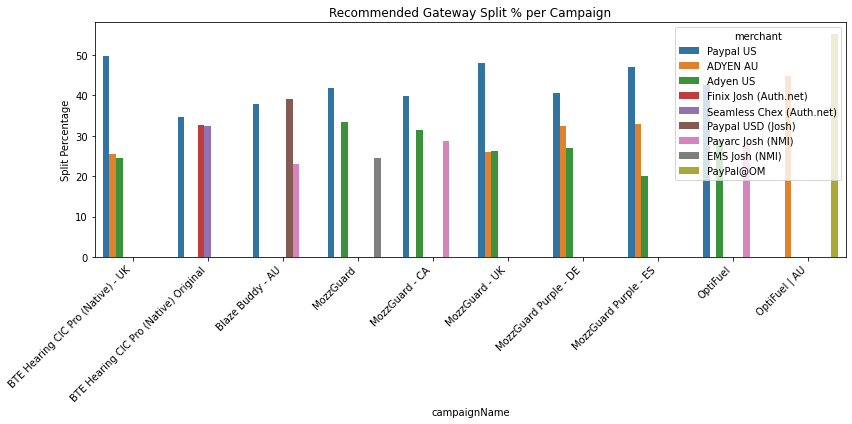

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_gateways_per_campaign,
    x="campaignName",
    y="recommended_split_percent",
    hue="merchant"
)
plt.title("Recommended Gateway Split % per Campaign")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Split Percentage")
plt.tight_layout()
plt.show()


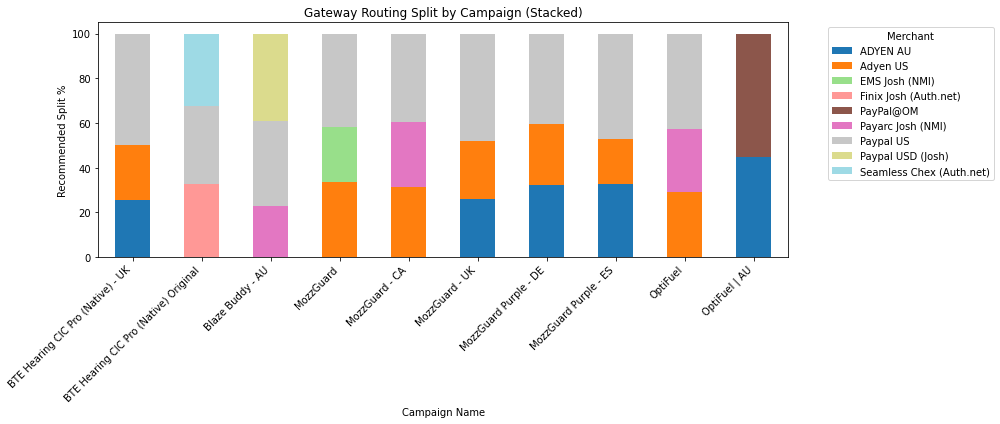

In [21]:
pivot_df = top_gateways_per_campaign.pivot_table(
    index='campaignName',
    columns='merchant',
    values='recommended_split_percent',
    fill_value=0
)

pivot_df.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='tab20')
plt.title("Gateway Routing Split by Campaign (Stacked)")
plt.ylabel("Recommended Split %")
plt.xlabel("Campaign Name")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Merchant', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


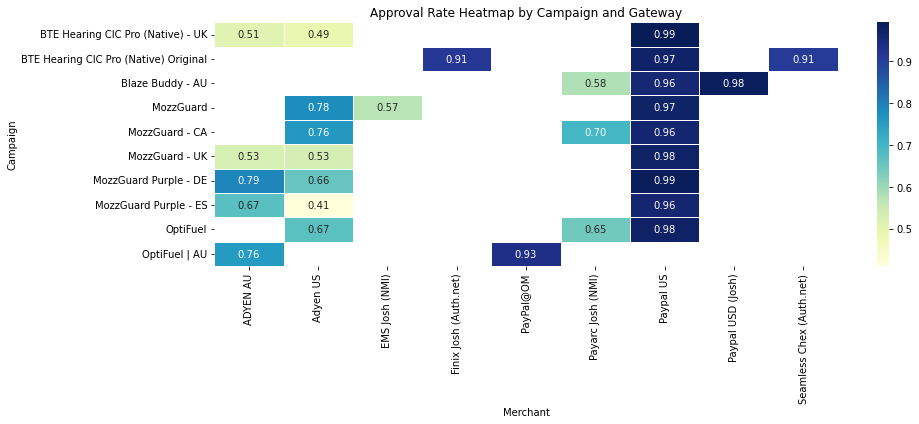

In [22]:
heatmap_data = top_gateways_per_campaign.pivot(
    index="campaignName",
    columns="merchant",
    values="approval_rate"
)

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title("Approval Rate Heatmap by Campaign and Gateway")
plt.ylabel("Campaign")
plt.xlabel("Merchant")
plt.tight_layout()
plt.show()


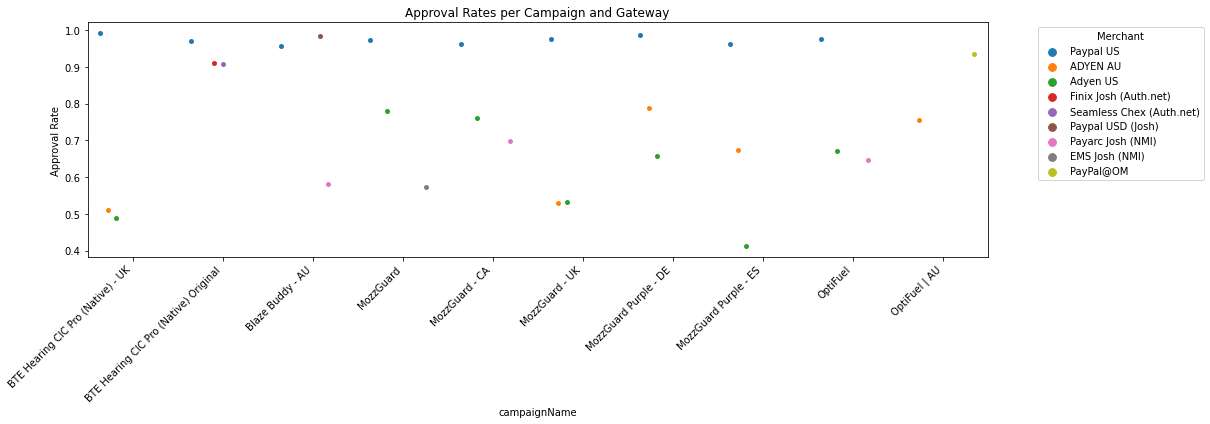

In [23]:
plt.figure(figsize=(14, 6))
sns.stripplot(
    data=top_gateways_per_campaign,
    x="campaignName",
    y="approval_rate",
    hue="merchant",
    dodge=True,
    jitter=True
)
plt.title("Approval Rates per Campaign and Gateway")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Approval Rate")
plt.tight_layout()
plt.legend(title="Merchant", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


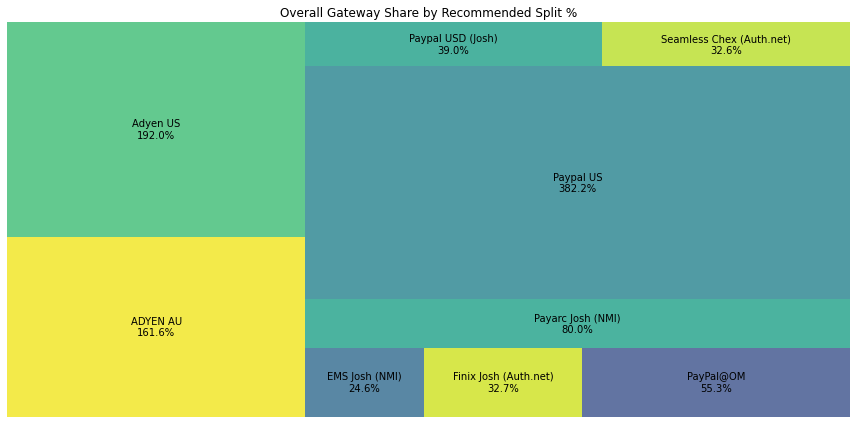

In [24]:
!  pip install squarify
import squarify

agg = top_gateways_per_campaign.groupby('merchant')['recommended_split_percent'].sum().reset_index()

plt.figure(figsize=(12, 6))
squarify.plot(
    sizes=agg['recommended_split_percent'],
    label=agg['merchant'] + "\n" + agg['recommended_split_percent'].round(1).astype(str) + '%',
    alpha=0.8
)
plt.title("Overall Gateway Share by Recommended Split %")
plt.axis('off')
plt.tight_layout()
plt.show()


In [25]:
# Merge currency info into top_gateways_per_campaign
# Get currencyCode per campaign from original filtered CIT data
campaign_currency = (
    cit_df[['campaignName', 'currencyCode']]
    .drop_duplicates()
    .set_index('campaignName')
)

top_gateways_per_campaign = top_gateways_per_campaign.merge(
    campaign_currency, on='campaignName', how='left'
)

# Apply international gateway restrictions
def is_valid_gateway(row):
    currency = row['currencyCode']
    merchant = row['merchant']
    
    if currency in ['AUD', 'EUR', 'GBP']:
        # Only Adyen US and Adyen AU are allowed
        return merchant in ['Adyen AU', 'Adyen US']
    else:
        # USD and CA-USD can use any gateway
        return True

# Keep only valid merchant-currency combinations
top_gateways_per_campaign = top_gateways_per_campaign[
    top_gateways_per_campaign.apply(is_valid_gateway, axis=1)
].copy()

# Recompute recommended_split_percent after removing disallowed gateways
def compute_gateway_split(df):
    total = df['approval_rate'].sum()
    df['recommended_split_percent'] = round((df['approval_rate'] / total) * 100, 2)
    return df

top_gateways_per_campaign = (
    top_gateways_per_campaign
    .groupby('campaignName', group_keys=False)
    .apply(compute_gateway_split)
)

# Optional: sort by campaign and recommended split
top_gateways_per_campaign = top_gateways_per_campaign.sort_values(
    by=['campaignName', 'recommended_split_percent'], ascending=[True, False]
)

# Save to CSV
top_gateways_per_campaign[
    ['campaignName', 'merchant', 'currencyCode', 'approval_rate', 'recommended_split_percent']
].to_csv('top_cit_gateways_split.csv', index=False)


C:\Users\shailja tiwari\AppData\Local\Temp\ipykernel_9244\628873170.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_gateways_per_campaign


In [26]:
top_gateways_per_campaign

,campaignName,merchant,hard_decline,pending,soft_decline,success,total_txns,approval_rate,recommended_split_percent,currencyCode
2,BTE Hearing CIC Pro (Native) - UK,Adyen US,21,0,536,535,1092,0.489927,100.00,GBP
3,BTE Hearing CIC Pro (Native) Original,Paypal US,0,0,14,451,465,0.969892,34.76,USD
4,BTE Hearing CIC Pro (Native) Original,Finix Josh (Auth.net),69,0,2,737,808,0.912129,32.69,USD
5,BTE Hearing CIC Pro (Native) Original,Seamless Chex (Auth.net),8,0,0,79,87,0.908046,32.55,USD
6,Blaze Buddy - AU,Paypal USD (Josh),0,0,1,65,66,0.984848,39.05,USD
7,Blaze Buddy - AU,Paypal US,0,0,9,197,206,0.956311,37.92,USD
8,Blaze Buddy - AU,Payarc Josh (NMI),15,0,24,54,93,0.580645,23.02,USD
9,MozzGuard,Paypal US,0,0,11,404,415,0.973494,41.88,USD
10,MozzGuard,Adyen US,2,0,32,120,154,0.779221,33.52,USD
11,MozzGuard,EMS Josh (NMI),78,0,65,191,334,0.571856,24.60,USD


In [27]:
import os
os.path.abspath('top_cit_gateways_split.csv')

'C:\\Users\\shailja tiwari\\top_cit_gateways_split.csv'

In [ ]:
# also want four gateway per campaign and remove all paypal transactions from calculations

In [29]:
top_gateways_per_campaign

responseType,campaignName,merchant,hard_decline,pending,soft_decline,success,total_txns,approval_rate
0,BTE Hearing CIC Pro (Native) - UK,Paypal US,0,0,4,523,527,0.992410
1,BTE Hearing CIC Pro (Native) - UK,ADYEN AU,12,0,42,56,110,0.509091
2,BTE Hearing CIC Pro (Native) - UK,Adyen US,21,0,536,535,1092,0.489927
3,BTE Hearing CIC Pro (Native) Original,Paypal US,0,0,14,451,465,0.969892
4,BTE Hearing CIC Pro (Native) Original,Finix Josh (Auth.net),69,0,2,737,808,0.912129
5,BTE Hearing CIC Pro (Native) Original,Seamless Chex (Auth.net),8,0,0,79,87,0.908046
6,BTE Hearing CIC Pro (Native) Original,Payarc Josh (NMI),36,0,9,86,131,0.656489
7,Blaze Buddy - AU,Paypal USD (Josh),0,0,1,65,66,0.984848
8,Blaze Buddy - AU,Paypal US,0,0,9,197,206,0.956311
9,Blaze Buddy - AU,Payarc Josh (NMI),15,0,24,54,93,0.580645


In [30]:
df.shape


(34254, 70)

In [31]:
print(df['items'].apply(type).value_counts())

items
<class 'list'>    34254
Name: count, dtype: int64


In [32]:
df['items'].head()


0    [{'productId': '23049', 'transactionItemId': '...
1    [{'productId': '7605', 'transactionItemId': '6...
2    [{'productId': '22684', 'transactionItemId': '...
3    [{'productId': '22684', 'transactionItemId': '...
4    [{'productId': '19351', 'transactionItemId': '...
Name: items, dtype: object

In [33]:
conda info --envs

# conda environments:
Note: you may need to restart the kernel to use updated packages.
#
base                  *  C:\ProgramData\Anaconda3


